# Whistling Keylock


In this notebook we will implement a simple "whistle-activated" keylock, that is, an access control system where the password is a pre-defined melody. To program the lock, you record your musical passphrase and then, to open the lock, you whistle it back. 

Although the implementation will be simple and skip most of the fine details that would be necessary to produce a truly robust system, we need to take into account at least the following points:
 * The system should be robust to noise and less than ideal recording conditions.
 * The system should recognize the passphrase even if the melody is faster or slower than the original.
 * Similarly, the system should ignore if the passphrase is in a different key signature than the original, that is, if it's whistled in a higher or lower register.
 
Our strategy will consist of the following steps:
 * Use the Short-Time Fourier Transform (STFT) to recover the pitch of the whistled notes.
 * Extract the musical intervals between different notes, discarding most of the finer melodic information.
 * Try to normalize the notes with respect to their underlying key signature.
 * Use Dynamic Time Warping (DTW) to compare the input to the original melody.

In [1]:
# first our usual bookkeeping
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy import signal
from scipy.io import wavfile

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams["font.size"] = 20

## 1. Extracting the pitch

### 1.1. The fundamental frequency
Pitch is defined as the "perceived frequency" of a sound. Most musical instruments (and the human voice) produce so-called _harmonic sounds_, that is, sounds whose spectrum consists of a series of peaks of varying amplitude at multiples of a _fundamental frequency_. For example, here is the spectrum of a note played on the piano:

In [3]:
Fs, x = wavfile.read("piano.wav")
# let's remove any DC component
x = x - np.mean(x)
IPython.display.Audio(x, rate=Fs)

In [4]:
# let's introduce here a handy function to plot spectral magnitudes using real-world frequency labeling
def plotSpecMag(Fs, x, fmax=Fs/2):
    N = int(len(x) * fmax / Fs / 2)
    X = np.abs(np.fft.fft(x))[0:N]
    f = fmax * np.arange(0, N) / N
    plt.plot(f, X)
    plt.xlabel("Frequency [Hz]")
    ax = plt.gca()
    ax.axes.yaxis.set_ticklabels([])
    plt.xlim([0, fmax])
    plt.grid();

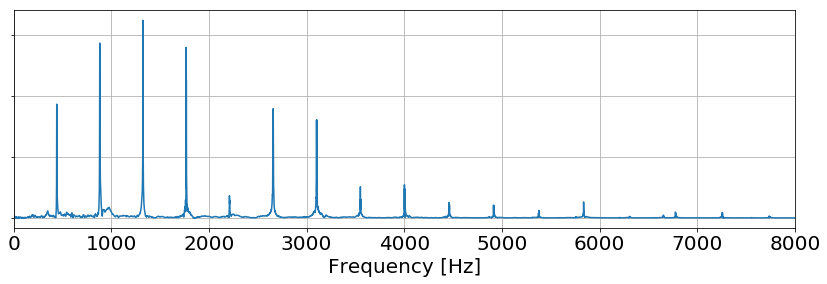

In [5]:
plotSpecMag(Fs, x)

If we zoom in on the frequency plot, we can see that the frequency of the first partial is around 440Hz, which corresponds to the note A4 (in concert pitch): <img src="330px-A440.png" width="200" />

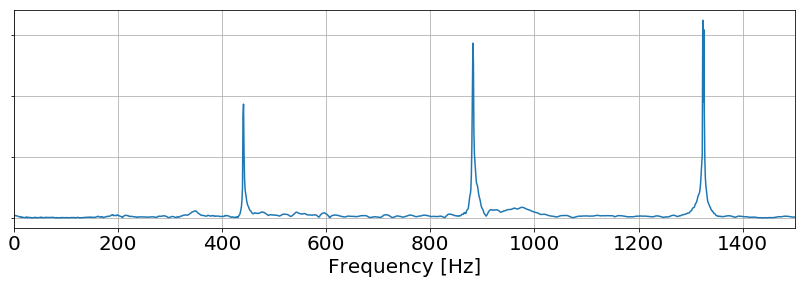

In [6]:
plotSpecMag(Fs, x, fmax=1500)

However, by looking at the full spectrum, you can also notice that the partial at the fundamental frequency is not the one with the largest magnitue. This is actually quite a common occurrence in musical sounds and it has the unfortunate consequence of making pitch extraction a bit complicated in practice. Indeed, especially in the presence of noise, locating the first partial can be difficult and requires us to look at the full spectral structure of the harmonic sound. 

Fortunately for us, however, human whistling produces a sinusoid-like sound that contains only a single spectral line. Here is an example:

In [8]:
Fs, s = wavfile.read("a6.wav")
IPython.display.Audio(s, rate=Fs)

In [9]:
# let's introduce here a handy function to plot spectral magnitudes using real-world frequency labeling
def plotSpecMag(Fs, x, fmax=Fs/2):
    N = int(len(x) * fmax / Fs / 2)
    X = np.abs(np.fft.fft(x))[0:N]
    f = fmax * np.arange(0, N) / N
    print(f[np.argmax(X)])
    plt.plot(f, X)
    plt.xlabel("Frequency [Hz]")
    ax = plt.gca()
    ax.axes.yaxis.set_ticklabels([])
    plt.xlim([0, fmax])
    plt.grid();

1834.883011190234


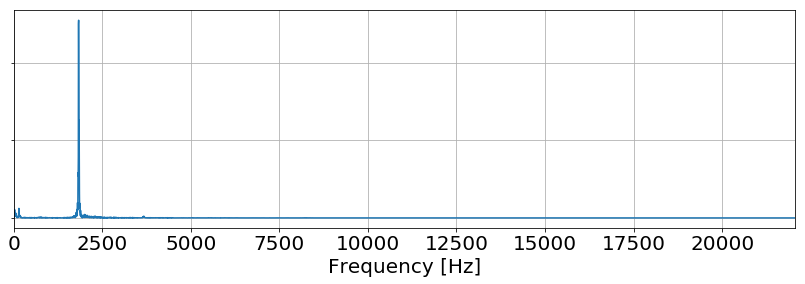

In [10]:
# subtract mean to remove DC offset
plotSpecMag(Fs, s-np.mean(s))

If you zoom in on the spectral line, you will see that the peak is approximately at 1760Hz; since $1760 = 2\cdot (2\cdot 440)$, the note is an A6, that is, an A two octaves above A4. 

The simple spectral structure of a whistled sound will allow us to greatly simplify two of our tasks:
 1. We will be able to determine if a signal contains a whistle by checking if the spectrum contains a sharp peak.
 1. Pitch extraction will correspond to simply **finding the maximum of the spectral magnitude**.

### 1.2. Time-frequency resolution and temperament

Musical phrases are based on the notion of note _intervals_, that is, a melody is defined by the _ratios_ of the fundamental frequencies of successive notes. Because of this, we can freely _transpose_ a melody, namely, sing it or whistle it in a higher or lower register, without changing its recognizability (of course, when people fail to agree on the starting note, you have terrible out-of-tune singing. Think of the last time you sang "Happy Birthday" to a friend!) Transposition therefore means _multiplying_ all the frequncies in a melody by a constant factor: in doing so, the relative intervals between notes remain the same.

In Western music the key interval is the _octave_, defined by two notes for which the frequency of the second is twice that of the first. Functionally, two notes an octave apart "sound" the same, and that's why we use the same name for both of them. The piano note at 440Hz that we played before was an A4, that is, an A in the fourth octave; a note with a frequency of 880Hz is called an A5. 

Next, this interval of one octave is subdivided into 12 semitones, corresponding to the twelve notes in the chromatic scale (C, C#, D, D#, E, F, F#, G, G#, A, A#, B, and the C again, an octave higher). In the common [_equal temperament_](https://en.wikipedia.org/wiki/Equal_temperament), the frequency ratio between two successive semitones is constant and equal to $\sqrt[12]2$. Again, consider our 440Hz A4: the next note on the chromatic scale is A#4 (on a piano, that would be the black key to the right of the white key for A4) whose frequency is 

$$440\sqrt[12]2 = 466.16\mbox{Hz}$$

Clearly, the frequency separation between neighboring notes on the Western scale is proportional to their frequency and increases with the pitch. 

Back to our pitch extraction algorithm, if we want to be able to recognize the notes of a whistled melody (on a Western scale) we need to be able to resolve frequency differences of at least a semitone and this imposes a minimum length on the size of the DFT used to locate the pitch.

Remember that, given a signal $x[n]$ of length $N$, the DFT algorithm will return a vector of $N$ frequency values. If the underlying sampling frequency for the discrete-time signal is $F_s$, the DFT resolution (i.e. the frequency separation between neighboring DFT values) will be $F_s/N$.

In general, the minimum frequency of a human whistle is about 700Hz. At this frequency, the interval spanned by a semitone is $700(\sqrt[12] 2 -1)\approx 42\mbox{Hz}$. In order to resolve at least a semitone, the frequency resolution of the DFT must therefore be on the order of 42Hz, which implies **a minimum length for the analysis window of at least 1/42 = 24ms**. 

## 2. Extracting the melody

The "melodic passphrase" to a whistling keylock is a sequence of notes of different pitches and durations (and, possibly, silent pauses between them, although we will ignore those). In this next step we will address the problem of segmenting an input audio file in order to extract this sequence of notes in the correct order. As an example, we will use the following simple 6-note tune (whistled in the 6th octave):
<img src="tune.png" width="400" />

In [11]:
Fs, ppA = wavfile.read("ppA.wav")
IPython.display.Audio(ppA, rate=Fs)

### 2.1. Multiple notes

Taking the Fourier transform of a signal containing multiple notes will reveal all the frequencies in the signal but will completely obfuscate the timing information, that is, the correct sequence in which the notes occur. In order to avoid this ambiguity we will use a time-frequency analysis known as Short-Time Fourier Transform (STFT) to analyze successive short slices of the audio input. We know from the previous section that we will need to use segments that are at least 24ms long. 

Each short segment should be examined to see if it contains a whistle or not. We perform this classification by looking at the spectrum and determining whether it contains a single peak. Here for example you can see the difference in shape between a segment containing noise and a segment containing a whistle.

0.0
2910.6


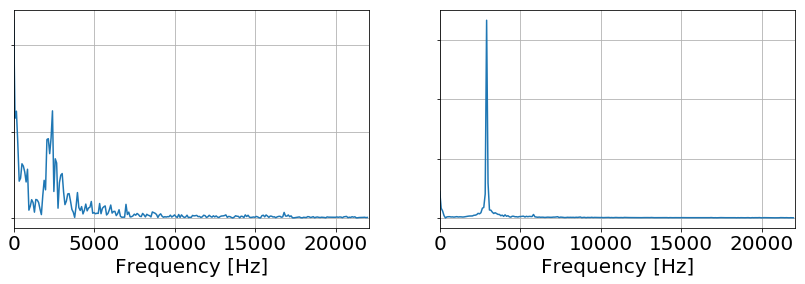

In [12]:
plt.subplot(1, 2, 1)    
plotSpecMag(Fs, ppA[:1024])

plt.subplot(1, 2, 2)    
plotSpecMag(Fs, ppA[80000:81000])

To determine if a segment contains a whistle we will find the position of the maximum in the spectral magnitude between 700Hz and 3000Hz and then check if most (say 80%) of the energy in the segment is captured by the peak

With this, the pitch extraction algorithm will perform the following operations:
 1. Split the signal into small segments.
 2. Perform a DFT on each segment.
 3. Look for a spectral peak in the 700 to 3000Hz range.
   * If no peak or if the peak is not narrow enough, mark the segment as silence.
   * Otherwise, extract the frequency of the note.

In [13]:
def transcribe(Fs, x):
    # min and max frequencies of human whistle
    WHISTLE_MIN_HZ = 700 
    WHISTLE_MAX_HZ = 3000

    # STFT segment length in milliseconds
    WIN_LEN_MS = 24
    # bins around the peak to detect peak energy
    PEAK_WIDTH = 3
    # energy ratio to detect whistled frames
    E_RATIO = 0.8
    
    # length of the segment in samples
    win_len = int(WIN_LEN_MS * Fs / 1000.0)
    # frequency resolution of the DFT
    freq_res = float(Fs) / win_len
    # first and last frequency indices for the whistling range
    min_bin = int(WHISTLE_MIN_HZ / freq_res)
    max_bin = int(WHISTLE_MAX_HZ / freq_res)
    
    # normalize audio amplitude to 1
    x = np.array(x) / max(x)

    pitch = []
    for n in range(0, len(x)-win_len, win_len):
        # DFT square magnitude for the segment, cut over freq interval of interest
        s = np.square(np.abs(np.fft.fft(x[n:n+win_len])[min_bin:max_bin])) 
        # location of the max
        p = np.argmax(s)
        # energy around the peak vs total energy
        k = np.sum(s[max(p-PEAK_WIDTH, 0):min(p+PEAK_WIDTH+1,len(s))])
        # if whistled frame, append pitch (ignore all other segments)
        if k > E_RATIO * np.sum(s):
            pitch.append(freq_res * (p + min_bin))
    return np.trim_zeros(np.array(pitch)) 

Let's try to extract the pitch from our sample:

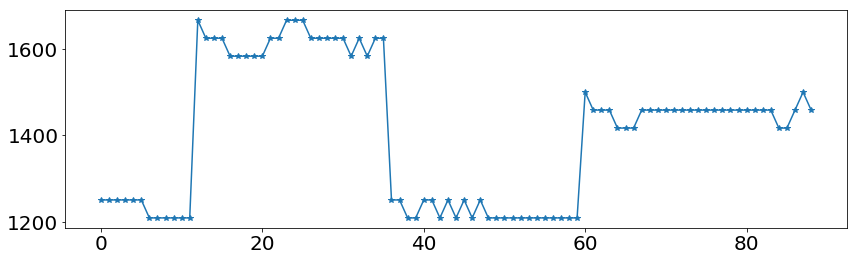

In [14]:
p = transcribe(Fs, ppA)
plt.plot(p, '*-');

For a quick check that our tool to extract the melody indeed works, we can try to re-synthesize the input with a sinusoidal oscillator. You can hear that we're doing a good job although the frequency is a bit wobbly -- this is due to the fact that for most people whistling is a bit imprecise. We will address this issues shortly. 

In [15]:
def synthesize(p):
    fs = 16000
    win_len = int(25 * fs / 1000.0)
    x = np.zeros((len(p) * win_len))
    theta = 0
    for n in range(0, len(p)):
        if p[n] != 0:
            for m in range(0, win_len):
                x[n * win_len + m] = cos(theta)
                theta += 2 * np.pi * p[n] / fs
    return x

In [16]:
IPython.display.Audio(synthesize(p), rate=16000)

## 3. Comparing two passphrases

OK, this is where things become a bit difficult. Now that we have a way to extract the sequence of pitches in a passkey, it would be tempting to just take some form of distance measure (such as the mean square error) between the original passkey and the input to see how close they are. Unfortunately this will hardly ever work because of two reasons:
 1. The user may whistle the same tune but at a different speed.
 1. The user may whistle the same tune but in a different musical key (that is, transposed to a different pitch).
 
We need to build a system that is robust to both issues. Let's start with the problem of key transposition.

### 3.1 Estimating the reference frequency

As we have seen, melodies are defined in terms of the frequency ratios between successive notes. Another way to look at a melody is to fix a reference note and then express all other notes as a multiple of this fundamental tone (also known as the "key" of a piece, but using this term would be confusing since we're designing a *key*lock). 

Take for example the passphrase we used above: it contains the notes D6, G6, F6 (ignoring duplicates). Frequency-wise, we have the tuple $[1174.66, 1567.98, 1396.91]$; we can "collect" the first frequency $f_0 = 1174.66$ and rewrite the tuple as $[f_0, f_0 s^5, f_0 s^3]$ where $s = \sqrt[12] 2$, that is, we can express each note in terms of a base key frequency. 

If we now transpose the melody, as in the following example, what we're doing is simply changing the value of $f_0$, while the relative intervals stay the same

In [17]:
Fs, ppAup = wavfile.read("ppAup.wav")
IPython.display.Audio(ppAup, rate=Fs)

In the above example, the passphrase has been transposed up by a full tone, so that in this case the notes involved in the melody are $[f_1, f_1 s^5, f_1 s^3]$ with $f_1 = 1318.51\mbox{Hz}$ (an E6).

Since we want to compare melodic lines that could be in different musical keys, ideally we would like to estimate the base frequency and use it normalize the transcription. One possibility would be to determine the first note of the passphrase and take that as the reference; this does not work very well, however, because, if the first note is slightly out of tune (not everyone is a pro whistler), then the whole normalization becomes wrong. 

A better approach is the following: assume we knew the sequence of notes in the melody expressed, as before, as multiples of the reference frequency, e.g. $[f_0, f_0 s^5, f_0 s^3]$. Consider now the following facts:
 * for whistling frequencies, $f_0 \gg s$
 * most passphrases will not span more than an octave
 * for $n \le 12$, $1 \le s^n \le 2$

With this, if we take the average of frequencies of the notes in the melody, we get a good estimate of $f_0$. Now, this does not mean that we can simply average the results of the transcription, because then the average will be dependent on the duration of each note. Instead, we need to segment the passphrase and extract each note individually.

To do so, we will split the transcription every time the melody jumps up and down by at least one full tone; we use a threshold larger than a semitone to avoid small pitch errors. Then we will average the frequency values between the found boundaries and only then we will average the set of musical notes to provide a normalization frequency:

In [18]:
def estimateBaseFreq(p):
    THRESHOLD = (1.05946309435929526456182529494634) ** 2
    s = np.trim_zeros(np.array(p))
    # first note
    notes = []
    ix = 0
    for c in range(1, len(p)):
        # add a new note only if we're jumping up or down at least a whole tone
        if s[c] > s[c-1] * THRESHOLD or s[c] < s[c-1] / THRESHOLD:
            notes.append(np.mean(s[ix:c]))
            ix = c
    return np.mean(np.array(notes))

We can now try to use the normalization procedure to compare the two passphrases in different keys: first let's plot their non-normalized transcriptions:

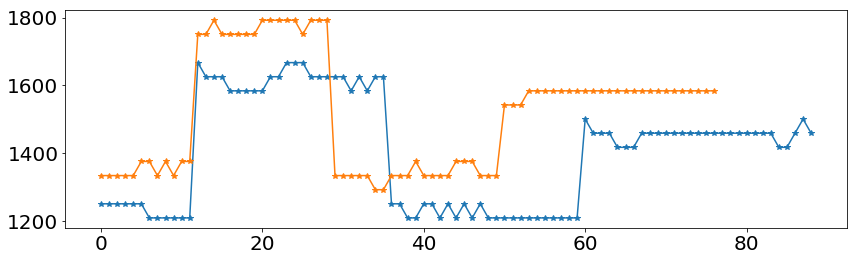

In [19]:
for k in (ppA, ppAup):
    plt.plot(transcribe(Fs, k), '*-')

We can see that the frequencies do not align. Now let's try with the normalization:

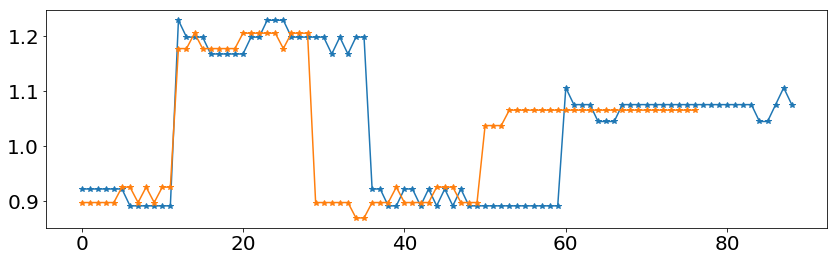

In [20]:
for k in (ppA, ppAup):
    p = transcribe(Fs, k)
    p = p / ss(p)
    plt.plot(p,'*-')

Cool! Seems we're on the right track -- although of course we still need to account for the different timing of the passphrases!

### 3.2 Dynamic Time Warping

Now that we have two (relatively) normalized sequences of pitches, it's time to compare them in a way that is as independent as possible of the total duration of each sequence. In other words, we need a distance measure that is insensitive to stretching of the time base. This is a very well-known problem in the domain of speech recognition, where utterances from faster and slower speakers must be compared to work and sentence templates in order to extract meaning. 

The solution is an algorithm called Dynamic Time Warping (DTW). Wikipedia has an excellent page on DTW and therefore we will not repeat a thorough analysis of the problem and its solution here. In a nutshell, however, suppose you have two strings of symbols, $S_A$ and $S_B$, of length $A$ and $B$ respectively. The idea behind DTW is to build an $A \times B$ matrix $D$ where each element contains the distance between each pair of elements from each string:

$$
    D_{n,m} = d(S_A[n], S_B[m])
$$

The DTW algorithm finds a minimum-cost path across the matrix connecting $D_{0,0}$ to $D_{A-1, B-1}$ and this cost represents the minimum distance (in terms of the cost function $d(\cdot, \cdot)$) between the strings.

The code is straightforward:

In [21]:
def dtw(a, b):
    D = np.zeros((len(a), len(b)))
    D[1:, 0] = np.inf
    D[0, 1:] = np.inf
    for i in range(0, len(a)):
        for j in range(0, len(b)):
            d = np.abs(a[i] - b[j])
            D[i, j] = d + np.min([D[i-1,j], D[i, j-1], D[i-1, j-1]])
    return D[-1, -1]

To accept or reject a passphrase we finally need to find a meaningful threshold for the value returned by the DTW algorithm. We will do this empirically by computing the in-group and cross-group distances between two sets of whistled melodies.

The first group contains variations of the tune we have used so far:

In [22]:
groupA = ["ppA.wav", "ppAup.wav", "ppAslow.wav", "ppAfast.wav", ]

while the second group contains variations of a different short melody (you can load and play these files to get an "acoustic" idea):

In [23]:
groupB = ["ppB.wav", "ppBslow.wav", "ppBdown.wav"]

Let's first compute the normalized transcriptions for each sound file

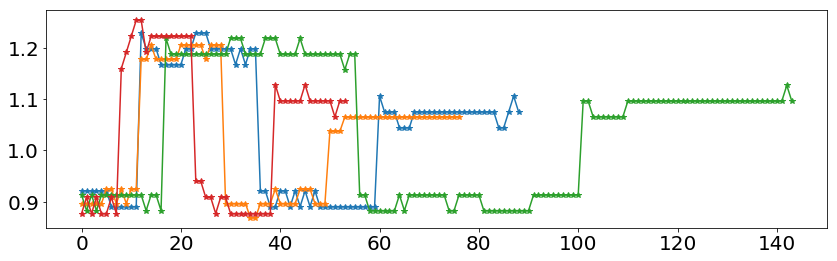

In [24]:
A = []
for filename in groupA:
    Fs, xx = wavfile.read(filename)
    t = transcribe(Fs, xx)
    k = estimateBaseFreq(t)
    A.append(t / k)
    plt.plot(A[-1],'*-')

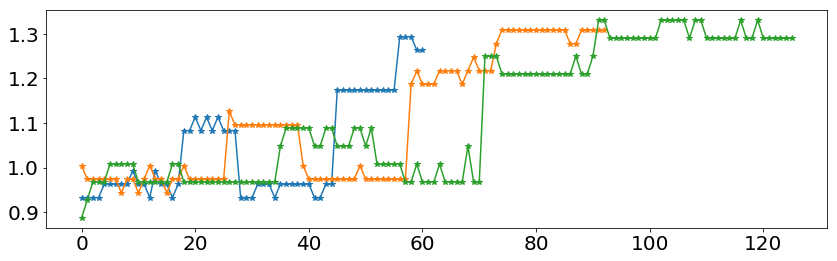

In [25]:
B = []
for filename in groupB:
    Fs, xx = wavfile.read(filename)
    t = transcribe(Fs, xx)
    k = estimateBaseFreq(t)
    B.append(t / k)
    plt.plot(B[-1],'*-')

Now compute the in-group DTW for both groups

In [26]:
for n in range(0, len(A)):
    for m in range(n+1, len(A)):
        print(n, m, dtw(A[n], A[m]))

0 1 1.2092478059523077
0 2 1.7949879374579107
0 3 1.50774223273961
1 2 2.5840783603458997
1 3 1.6151682301573282
2 3 1.5160234564298953


In [27]:
for n in range(0, len(B)):
    for m in range(n+1, len(B)):
        print(n, m, dtw(B[n], B[m]))

0 1 1.832957526516897
0 2 2.4222526717515445
1 2 1.9116748119219695


Finally, let's compute the cross-distance between the two groups

In [28]:
for n in range(0, len(A)):
    for m in range(0, len(B)):
        print(n, m, dtw(A[n], B[m]))

0 0 4.627191280779358
0 1 9.068512558850596
0 2 12.939545286284336
1 0 5.135250122035303
1 1 10.23160184333025
1 2 14.778468246184833
2 0 4.888663217031719
2 1 8.896543218942568
2 2 12.5813078833648
3 0 4.540512290609645
3 1 8.939647164831374
3 2 11.003313294414045


From this admittedly simple data set, it would seem that a threshold of about 3 would do the trick.

## 4. Testing it live!

In this last part of the notebook you can try your skills at opening the whistle-activated keylock. For the following blocks to execute, you must have the **sounddevice** Python library available on your system; if the following block doesn't execute correctly, try to install it via
```
pip install sounddevice
```

In [29]:
import sounddevice as sd

Here is a function that will record audio from your system's microphone and compare the passphrase you whistled with a template reference:

In [30]:
def keylock(sec, Fs, original_key):
    # s is the duration of the recording. original_key is the reference passphrase audio
    THRESHOLD = 3
    in_key = sd.rec(int(sec * Fs), samplerate=Fs, channels=1, blocking=True).flatten()
    k = []
    for audio in (in_key, original_key):
        t = transcribe(Fs, audio)
        k.append(t / estimateBaseFreq(t))
    d = dtw(k[0], k[1])
    if d < THRESHOLD:
        print("OPEN SESAME!")
    else:
        print("no dice {}".format(d))

First let's see if you can open the keylock by mimicking the original passphrase, which you can listen to again here

In [31]:
Fs, ppA = wavfile.read("ppA.wav")
IPython.display.Audio(ppA, rate=Fs)

When you execute the following block, the system will record a 3-second audio from your microphone; just whistle the passphrase and see if you manage to open the lock

In [38]:
keylock(3, Fs, ppA)

OPEN SESAME!


Finally, you can try to record your own passphrase and see how secure it is; choose your duration and whistle away

In [ ]:
KEY_LEN = 3 # seconds
Fs = 16000
passkey = sd.rec(int(KEY_LEN * Fs), samplerate=Fs, channels=1, blocking=True).flatten()

now try to open it (or cheat it!)

In [ ]:
keylock(KEY_LEN, Fs, passkey)

In [ ]:
# listen to your recording in case you forgot it ;)
# IPython.display.Audio(s, rate=Fs)
IPython.display.Audio(passkey, rate=Fs)